In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score  # 실루엣 점수 계산을 위한 임포트
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# 데이터 로드
DATA_PATH = "../data"
df = pd.read_csv(f"{DATA_PATH}/한국문화정보원_전국반려동물동반가능문화시설위치데이터_20221130.CSV", encoding='cp949')

# 1. '천안시 동남구'와 '천안시 서북구' 데이터 필터링
target_areas = ['천안시 동남구', '천안시 서북구']
df_filtered = df[df['시군구 명칭'].isin(target_areas)]

# 2. '동물병원', '동물약국', '반려동물용품', '미용', '위탁관리' 제외한 카테고리 필터링
exclude_categories = ['동물병원', '동물약국', '반려동물용품', '미용', '위탁관리']
df_filtered = df_filtered[~df_filtered['카테고리3'].isin(exclude_categories)]

# 필요한 컬럼만 선택
df_filtered = df_filtered[['시도 명칭', '시군구 명칭', '법정읍면동명칭', '카테고리3', '위도', '경도']]

# 원핫 인코딩 수행
df_onehot = pd.get_dummies(df_filtered[['카테고리3']], prefix="", prefix_sep="")

# 법정읍면동명칭을 인덱스로 설정
df_onehot['법정읍면동명칭'] = df_filtered['법정읍면동명칭']

# 법정읍면동명칭별로 그룹화하여 평균 계산
df_grouped = df_onehot.groupby('법정읍면동명칭').mean().reset_index()

# 클러스터링 수행 (df_grouped를 사용)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_grouped.drop('법정읍면동명칭', axis=1))

# 클러스터 레이블 추가
df_grouped['Cluster Labels'] = kmeans.labels_

# 실루엣 점수 계산
silhouette_avg = silhouette_score(df_grouped.drop(['법정읍면동명칭', 'Cluster Labels'], axis=1), kmeans.labels_)
print(f"n_clusters = {n_clusters}, silhouette score = {silhouette_avg}")

# 시각화를 위해 기존 데이터와 병합
final_merged = df_filtered[['법정읍면동명칭', '위도', '경도']].drop_duplicates()
final_merged = final_merged.merge(df_grouped[['법정읍면동명칭', 'Cluster Labels']], on='법정읍면동명칭')

# 클러스터별 카테고리 빈도 확인 (중복 제거)
clusterdata = pd.merge(df_onehot, df_grouped[['법정읍면동명칭', 'Cluster Labels']], on='법정읍면동명칭')

# 각 클러스터에서 숫자형 데이터의 평균을 구하여 비율로 변환
numeric_data = clusterdata.drop(['법정읍면동명칭'], axis=1)
cluster_avg = numeric_data.groupby('Cluster Labels').mean().transpose()

# 결과 확인
print(cluster_avg)

# 색상 설정
colors_array = cm.rainbow(np.linspace(0, 1, n_clusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# 지도 생성 및 시각화
map_clusters = folium.Map(location=[36.818, 127.156], zoom_start=12)

# 클러스터 시각화
for lat, lon, poi, cluster in zip(final_merged['위도'], final_merged['경도'], final_merged['법정읍면동명칭'], final_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)

# 결과 시각화
map_clusters


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 5, silhouette score = 0.6343044451990385
Cluster Labels         0    1         2    3         4
문예회관            0.000000  0.0  0.000000  1.0  0.166667
미술관             0.000000  0.0  0.000000  0.0  0.166667
박물관             0.777778  0.0  0.000000  0.0  0.166667
여행지             0.111111  0.0  0.916667  0.0  0.083333
카페              0.111111  1.0  0.083333  0.0  0.416667


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 2, silhouette score = 0.08314163175775696


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 3, silhouette score = 0.31097829274486116


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 4, silhouette score = 0.6274665543196107


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 5, silhouette score = 0.6343044451990385


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 6, silhouette score = 0.6224042142442341


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 7, silhouette score = 0.6357186905296959


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 8, silhouette score = 0.6168732182363459


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 9, silhouette score = 0.5816780096569302


c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gani\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters = 10, silhouette score = 0.5876741209110867


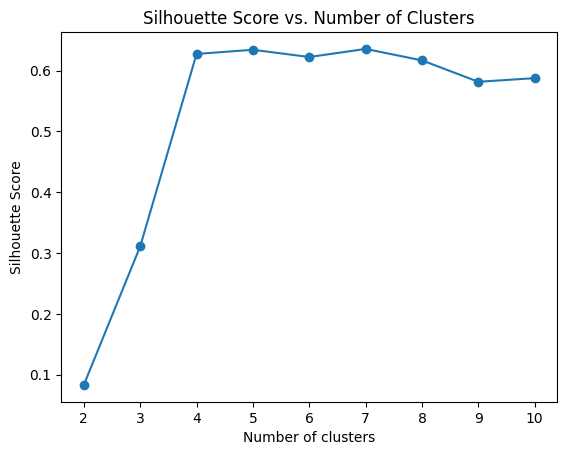

In [2]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# 클러스터 수 범위 설정
cluster_range = range(2, 11)
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_grouped.drop('법정읍면동명칭', axis=1))
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_grouped.drop(['법정읍면동명칭', 'Cluster Labels'], axis=1), labels)
    silhouette_scores.append(silhouette_avg)
    print(f"n_clusters = {n_clusters}, silhouette score = {silhouette_avg}")

# 최적 클러스터 수 시각화
import matplotlib.pyplot as plt

plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()
